## Capstone 2 Proposal: Customer Satisfaction in OList

One of the prominent e-commerce sites for sellers in Brazil is OList, a company that connects merchants and their products to the main marketplaces in the country. In order to maintain a balance in the relationship with merchants and customers they must monitor and maintain a number of different areas of their business such as customer satisfaction, product quality, and delivery performance. Being that OList is a relatively new privately owned company that is up and coming in Brazil, one of the most important factors in maintaining their brand reputation and integrity is customer satisfaction. Since OList connects merchants with customers it is important to identify which products in what areas are contributing to high satisfaction. Similarly, they need to monitor areas of low satisfaction and make decisions on how to manage them.

The purpose of my work will be to analyze customer satisfaction and identify what factors contribute to high and low ratings. What are the highest indicators of whether a product will be successful? What areas of the supply chain correlate most to customer satisfaction? How do successful merchants relate to one another, and similarly with unsuccessful ones? What types of products are most prone to polarizing ratings? When are customers more likely to be satisfied with their purchase? My goal is to use exploratory analysis as a starting point to investigate the overall problem of improving customer satisfaction, and by clearly identifying what areas are most important in determining the outcome of a product's success. 

I eventually want to predict customer satisfaction based on clustering techniques that may identify where more complex commonalities may occur. This can be done with scikit- learn's clustering library for grouping through unsupervised means. My approach will be informed by learnings from the exploratory and statistical analysis phases primarily and will use data from customer reviews and ratings along with merchant-ids and detailed product information. 

The data used is provided by [kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce/data?select=product_category_name_translation.csv) and details all aspects of customer and merchant transactions throughout their database. The data will be loaded from the website onto a local jupyter notebook where I will produce my final product. I plan to provide OList with recommendations of where to focus efforts in order to improve customer satisfaction in specific product areas. This will come in the form of a slide deck and code for reproducibility. 


### Load Data

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import datetime
import plotly.offline
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
sns.set()

In [2]:
def read_in_data(df_names, directory = './'):
    '''Read in data into seperate dataframes'''
    
    # change directory to data storage location
    os.chdir(directory)
    
    # list of filenames
    extension = 'csv'
    filenames = [i for i in glob.glob('*.{}'.format(extension))]
    
    # create global dfs within function
    for name, file in zip(df_names, filenames):
        globals()[name] = pd.read_csv(file)

In [3]:
# list of prefered dataframe names
df_names = ['sellers', 'translation', 'orders', 'order_items', 'customers', \
                'location', 'payments', 'reviews', 'products']
directory = 'olist_data'
read_in_data(df_names, directory)

#### Order Reviews Dataset
This dataset includes data about the reviews made by the customers.

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

In [4]:
def replace_na_with_text(df, column, new_text):
    '''replace missing text with preferred description'''
    
    # change missing data to appropriate label
    df[column] = df[column].replace(np.nan, new_text)

In [5]:
replace_na_with_text(df=reviews, column='review_comment_title', new_text='no title')
replace_na_with_text(df=reviews, column='review_comment_message', new_text='no comment given')

In [6]:
def timestamp_to_datetime(df, columns):
    
    for col in columns:
        df[col] = pd.to_datetime(df[col])

In [7]:
columns = ['review_creation_date', 'review_answer_timestamp']
timestamp_to_datetime(reviews, columns)

In [8]:
def lowercase(df, columns):
    '''change all text to lowercase'''
    for col in columns:
        df[col] = df[col].str.lower()

In [9]:
columns = ['review_comment_title', 'review_comment_title']
lowercase(reviews, columns)

In [10]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,no title,no comment given,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,no title,no comment given,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,no title,no comment given,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,no title,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,no title,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


#### Order Dataset
This is the core dataset. From each order you might find all other information.

In [11]:
# drop rows containing NaN values, this corresponds to no delivery
orders.dropna(inplace = True)
    
# drop canceled orders (3 remaining) and reset index
index_to_drop = orders[orders.order_status == 'canceled'].index
orders.drop(index_to_drop, inplace=True)
orders.reset_index(drop=True, inplace=True)

In [12]:
columns_to_datetime = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', \
                          'order_delivered_customer_date', 'order_estimated_delivery_date']
timestamp_to_datetime(orders, columns_to_datetime)

In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96455 entries, 0 to 96454
Data columns (total 8 columns):
order_id                         96455 non-null object
customer_id                      96455 non-null object
order_status                     96455 non-null object
order_purchase_timestamp         96455 non-null datetime64[ns]
order_approved_at                96455 non-null datetime64[ns]
order_delivered_carrier_date     96455 non-null datetime64[ns]
order_delivered_customer_date    96455 non-null datetime64[ns]
order_estimated_delivery_date    96455 non-null datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 5.9+ MB


In [14]:
orders.describe(exclude=object).T

,count,unique,top,freq,first,last
order_purchase_timestamp,96455,95933,2018-08-02 12:05:26,3,2016-09-15 12:16:38,2018-08-29 15:00:37
order_approved_at,96455,88266,2018-02-27 04:31:10,9,2016-09-15 12:16:38,2018-08-29 15:10:26
order_delivered_carrier_date,96455,80094,2018-05-09 15:48:00,47,2016-10-08 10:34:01,2018-09-11 19:48:28
order_delivered_customer_date,96455,95643,2018-05-14 20:02:44,3,2016-10-11 13:46:32,2018-10-17 13:22:46
order_estimated_delivery_date,96455,445,2017-12-20 00:00:00,507,2016-10-04 00:00:00,2018-10-25 00:00:00


In [15]:
orders.describe(exclude='datetime').T

,count,unique,top,freq
order_id,96455,96455,4ede14dc839603196ec790137877bf71,1
customer_id,96455,96455,842ef6046022a1d598171ceba0f88b84,1
order_status,96455,1,delivered,96455


#### Products Dataset
This dataset includes data about the products sold by Olist.


In [16]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
product_id                    32951 non-null object
product_category_name         32341 non-null object
product_name_lenght           32341 non-null float64
product_description_lenght    32341 non-null float64
product_photos_qty            32341 non-null float64
product_weight_g              32949 non-null float64
product_length_cm             32949 non-null float64
product_height_cm             32949 non-null float64
product_width_cm              32949 non-null float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [17]:
# drop products with no description
products.dropna(inplace = True)
products.reset_index(drop = True, inplace = True)

In [18]:
def translate_column_with_df(df_original, df_translation, column_original, column_translation): 
    '''Translate column, given df with translation'''
    
    # convert translation to dictionary to extract key, value pairs
    df_translation = df_translation.set_index(column_original)
    df_translation = df_translation.to_dict('dict')
    
    # map translations
    df_original[column_original] = df_original[column_original]\
                                               .map(df_translation[column_translation])

In [19]:
translate_column_with_df(products, translation, 'product_category_name', 'product_category_name_english')

In [20]:
products.describe(exclude=float).T

,count,unique,top,freq
product_id,32340,32340,63c0e572201a0411c48dd051f0b316ad,1
product_category_name,32327,71,bed_bath_table,3029


> Over 32,000 products within 71 categories

In [21]:
products.describe(exclude=object).T

,count,mean,std,min,25%,50%,75%,max
product_name_lenght,32340.0,48.476592,10.245699,5.0,42.0,51.0,57.0,76.0
product_description_lenght,32340.0,771.492393,635.124831,4.0,339.0,595.0,972.0,3992.0
product_photos_qty,32340.0,2.188961,1.736787,1.0,1.0,1.0,3.0,20.0
product_weight_g,32340.0,2276.956586,4279.291845,0.0,300.0,700.0,1900.0,40425.0
product_length_cm,32340.0,30.854545,16.955965,7.0,18.0,25.0,38.0,105.0
product_height_cm,32340.0,16.958813,13.636115,2.0,8.0,13.0,21.0,105.0
product_width_cm,32340.0,23.208596,12.078762,6.0,15.0,20.0,30.0,118.0


#### Sellers Dataset
This dataset includes data about the sellers that fulfilled orders made at Olist. Use it to find the seller location and to identify which seller fulfilled each product.

In [22]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [23]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
seller_id                 3095 non-null object
seller_zip_code_prefix    3095 non-null int64
seller_city               3095 non-null object
seller_state              3095 non-null object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


#### Customers Dataset
This dataset has information about the customer and its location. Use it to identify unique customers in the orders dataset and to find the orders delivery location.

At our system each order is assigned to a unique customerid. This means that the same customer will get different ids for different orders. The purpose of having a customerunique_id on the dataset is to allow you to identify customers that made repurchases at the store. Otherwise you would find that each order had a different customer associated with.

In [24]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [25]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
customer_id                 99441 non-null object
customer_unique_id          99441 non-null object
customer_zip_code_prefix    99441 non-null int64
customer_city               99441 non-null object
customer_state              99441 non-null object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


#### Order Items Dataset
This dataset includes data about the items purchased within each order.

In [26]:
timestamp_to_datetime(order_items, ['shipping_limit_date'])

In [27]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [28]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
order_id               112650 non-null object
order_item_id          112650 non-null int64
product_id             112650 non-null object
seller_id              112650 non-null object
shipping_limit_date    112650 non-null datetime64[ns]
price                  112650 non-null float64
freight_value          112650 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


#### Geolocation Dataset
This dataset has information Brazilian zip codes and its lat/lng coordinates. Use it to plot maps and find distances between sellers and customers.

In [29]:
location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
geolocation_zip_code_prefix    1000163 non-null int64
geolocation_lat                1000163 non-null float64
geolocation_lng                1000163 non-null float64
geolocation_city               1000163 non-null object
geolocation_state              1000163 non-null object
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [30]:
location.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [31]:
location.geolocation_zip_code_prefix.nunique()

19015

> location data seems to have many duplicates with miniscule lat and lng variations between each. Keeping only the first of each zip code will help avoid merge issues later on.

In [32]:
location.drop_duplicates(subset = ['geolocation_zip_code_prefix'], keep = 'first', inplace = True)

In [33]:
location.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19015 entries, 0 to 999846
Data columns (total 5 columns):
geolocation_zip_code_prefix    19015 non-null int64
geolocation_lat                19015 non-null float64
geolocation_lng                19015 non-null float64
geolocation_city               19015 non-null object
geolocation_state              19015 non-null object
dtypes: float64(2), int64(1), object(2)
memory usage: 891.3+ KB


#### Payments Dataset
This dataset includes data about the orders payment options.

In [34]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
order_id                103886 non-null object
payment_sequential      103886 non-null int64
payment_type            103886 non-null object
payment_installments    103886 non-null int64
payment_value           103886 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [35]:
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


### Combine data into 3 dataframes

In order to analyze customer ratings and seller influences, we will combine the data into dataframes related to their respective content.

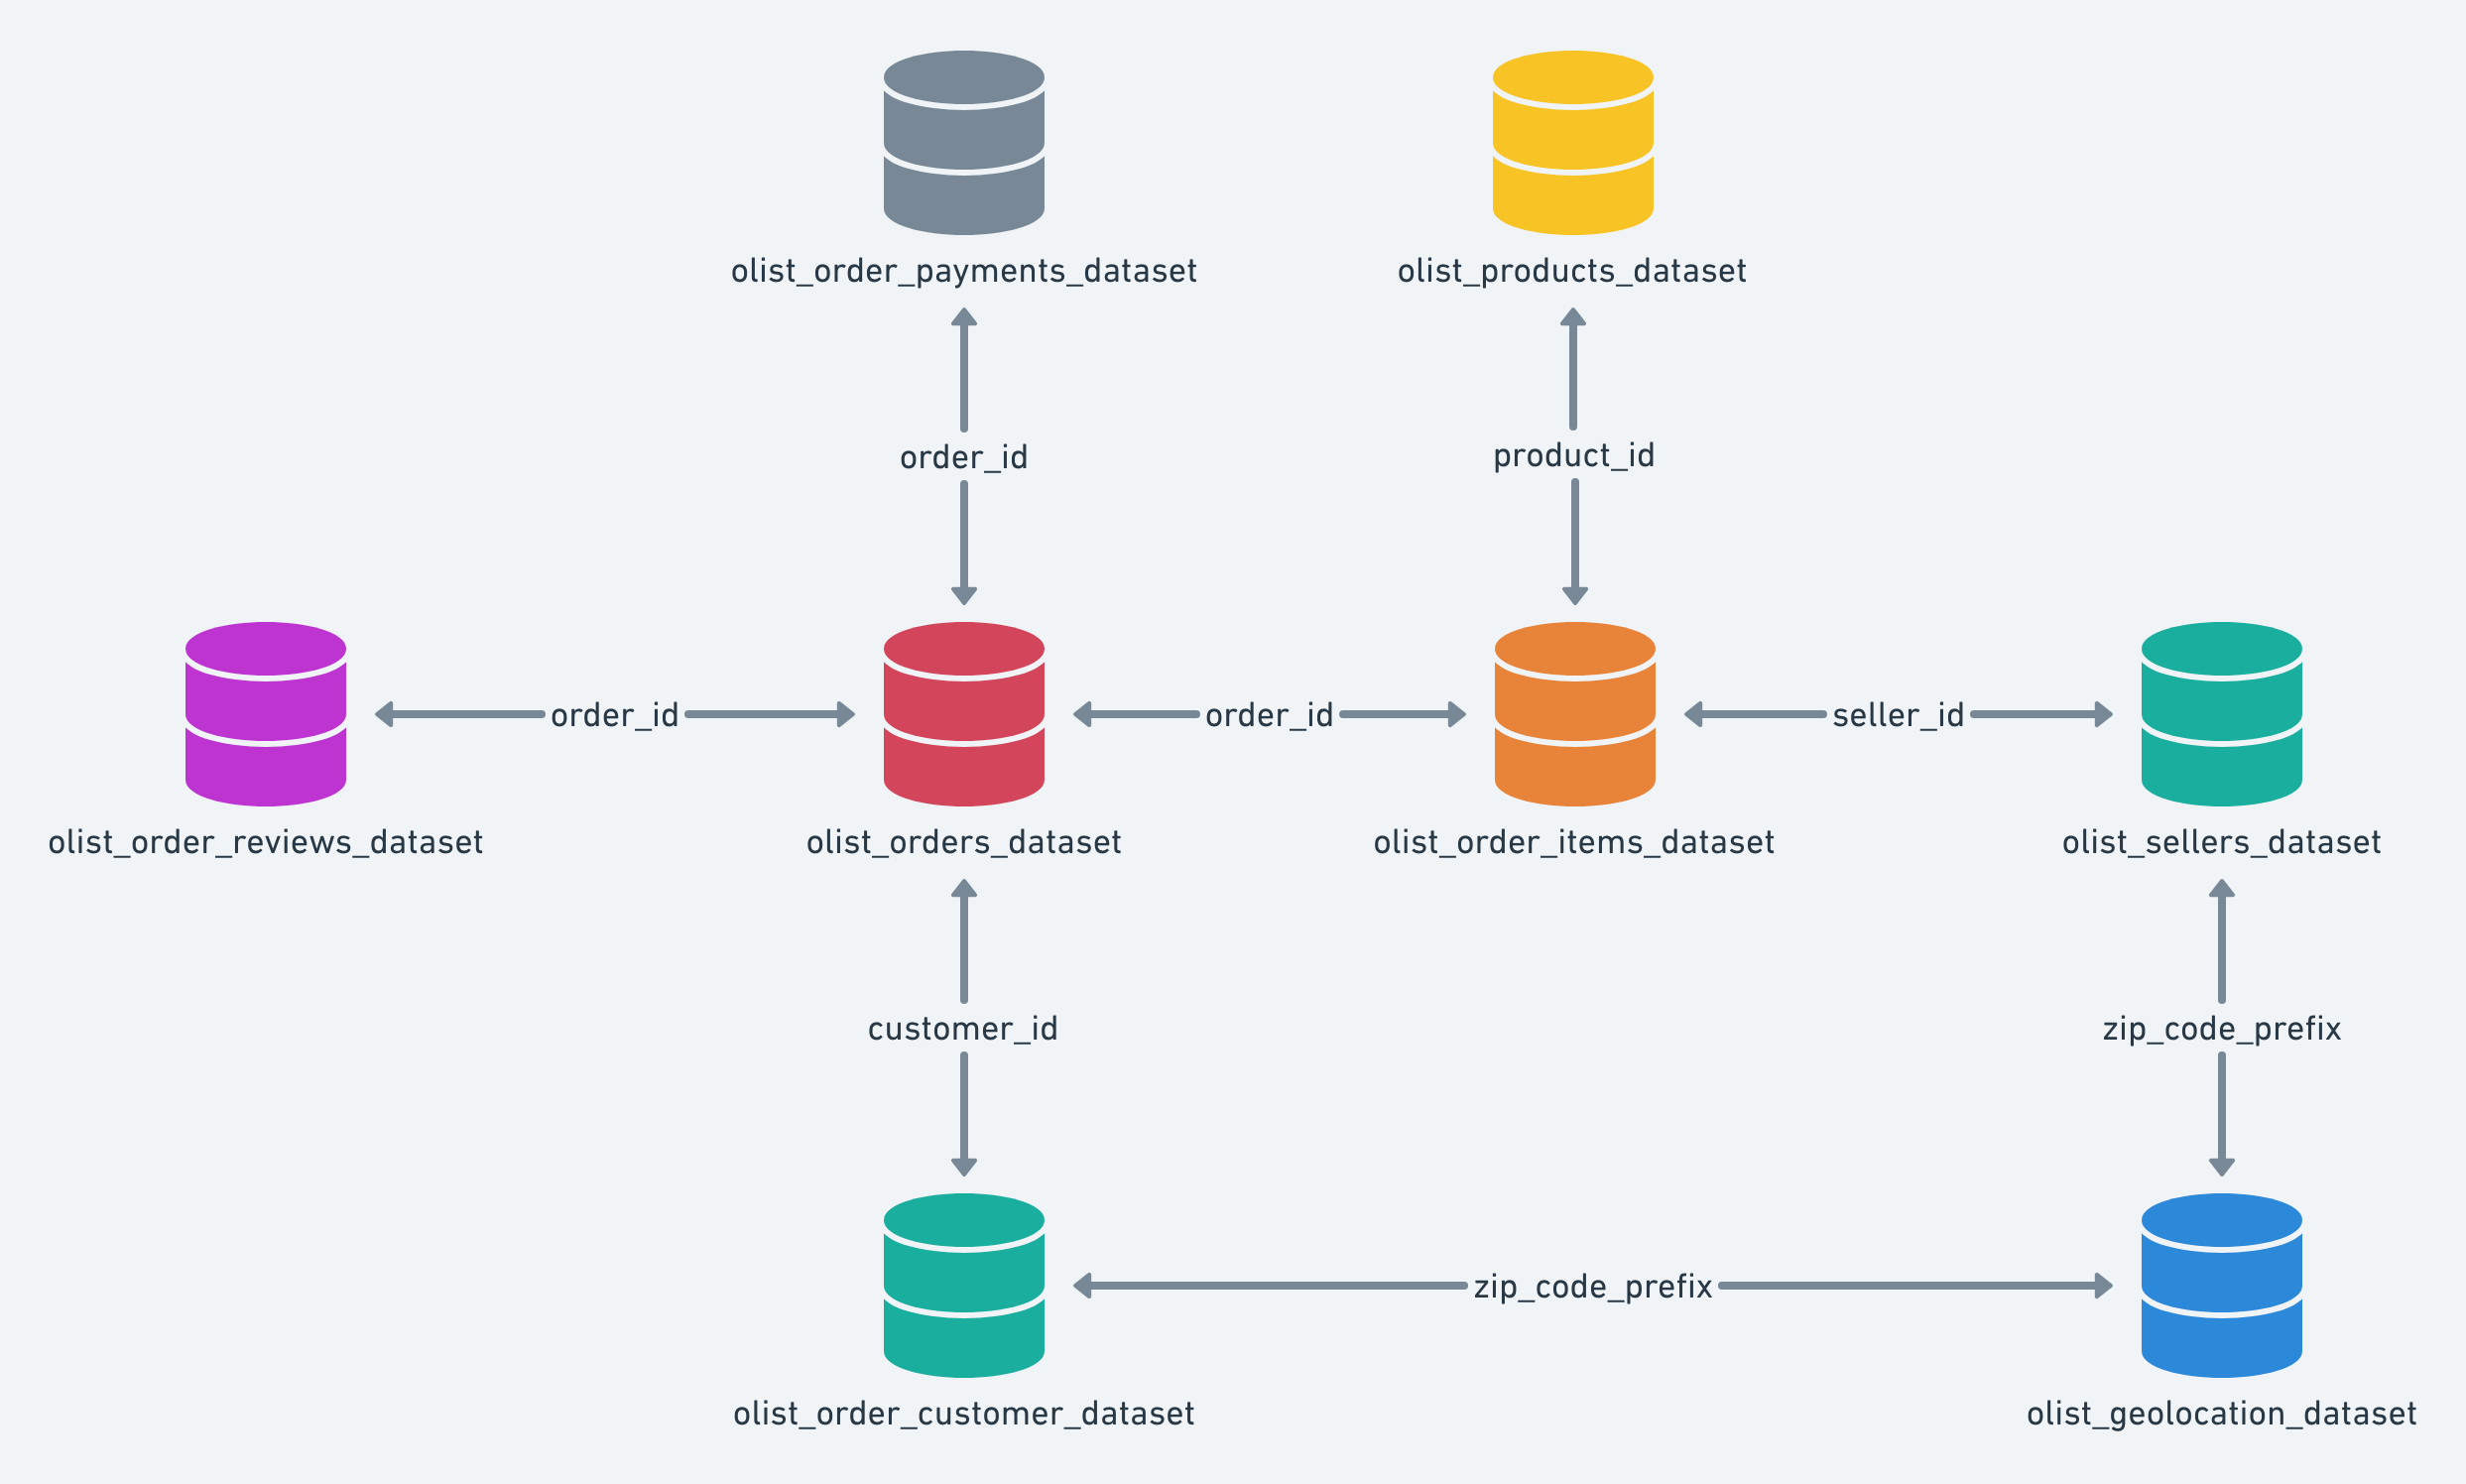


In [36]:
def merge_multiple_df_on_key(dfs, key):
    '''create dataframe with customer info including their location, order details and review'''
    
    from functools import reduce
    
    # stolen from https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns)
    new_df = reduce(lambda left,right: pd.merge(left,right, how = 'inner', on=key), dfs)
    
    return new_df

In [37]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [38]:
# dfs to merge with order_id column
dfs = [orders, order_items, reviews]
# merge on key
customer_purchases = merge_multiple_df_on_key(dfs, key = 'order_id')

In [39]:
def drop_duplicates_ignore_cols(df, cols_to_ignore, keep = 'first'):
    '''drop duplicates but ignore certain columns'''
    df.drop_duplicates(keep = keep, \
                       subset=df.columns.difference(cols_to_ignore), \
                       inplace=True)

In [40]:
# drop duplicate rows based on all columns except these
cols_to_ignore = ['review_id', 'review_answer_timestamp', 'review_creation_date']

# call function
drop_duplicates_ignore_cols(customer_purchases, cols_to_ignore)

In [41]:
# drop order delivery details, this will go into the seller_info df
cols_to_drop = orders.columns.difference(['order_id', 'customer_id', 'order_purchase_timestamp', \
                                          'order_delivered_customer_date', 'order_estimated_delivery_date'])
customer_purchases.drop(cols_to_drop, 1, inplace=True)

In [42]:
# set cols to drop after merging with location and customers
cols_to_drop = ['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state']
    
# merge with customers and location
customer_info = pd.merge(pd.merge(customer_purchases, customers, on = 'customer_id'), location, \
                             left_on ='customer_zip_code_prefix', \
                             right_on = 'geolocation_zip_code_prefix').drop(cols_to_drop, 1).reset_index(drop=True)

In [43]:
# need to merge product info to pull the product_category_name
customer_info = customer_info.merge(products, on = 'product_id')

In [44]:
# merge all dfs associated with seller
seller_info = pd.merge(pd.merge(pd.merge(pd.merge(order_items, \
                        sellers, on = 'seller_id'), \
                        products, on = 'product_id'), \
                        reviews, on = 'order_id'), \
                        location, how = 'inner', \
                                  left_on ='seller_zip_code_prefix', \
                                  right_on = 'geolocation_zip_code_prefix')

In [45]:
# drop redundant and unnecessary columns
cols_to_drop = ['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state', 'freight_value']
seller_info.drop(cols_to_drop, 1, inplace=True)
seller_info.reset_index(drop=True, inplace=True)

In [46]:
cols_to_ignore = ['review_id', 'review_answer_timestamp', 'review_creation_date']
drop_duplicates_ignore_cols(seller_info, cols_to_ignore)

In [47]:
seller_info.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,seller_zip_code_prefix,seller_city,seller_state,product_category_name,...,product_height_cm,product_width_cm,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,geolocation_lat,geolocation_lng
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,27277,volta redonda,SP,cool_stuff,...,9.0,14.0,97ca439bc427b48bc1cd7177abe71365,5,no title,"Perfeito, produto entregue antes do combinado.",2017-09-21,2017-09-22 10:57:03,-22.498183,-44.123614
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,27277,volta redonda,SP,cool_stuff,...,9.0,14.0,b11cba360bbe71410c291b764753d37f,5,no title,"lannister como sempre, entregou certinho e den...",2017-07-14,2017-07-17 12:50:07,-22.498183,-44.123614
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,27277,volta redonda,SP,cool_stuff,...,9.0,14.0,af01c4017c5ab46df6cc810e069e654a,4,super recomendo,carrinho muito bonito,2018-06-05,2018-06-06 21:41:12,-22.498183,-44.123614
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,27277,volta redonda,SP,cool_stuff,...,9.0,14.0,8304ff37d8b16b57086fa283fe0c44f8,5,no title,no comment given,2017-08-10,2017-08-13 03:35:17,-22.498183,-44.123614
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,27277,volta redonda,SP,cool_stuff,...,9.0,14.0,426f43a82185969503fb3c86241a9535,5,no title,no comment given,2017-08-25,2017-08-28 00:51:18,-22.498183,-44.123614


In [48]:
# set dfs to have common orders between them
sellers = seller_info[seller_info.order_id.isin(customer_info.order_id)]
customers = customer_info[customer_info.order_id.isin(seller_info.order_id)]

## Plot sellers and customer as graph

In [49]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

'''seller_geometry = [Point(xy) for xy in zip(seller_info.geolocation_lng, seller_info.geolocation_lat)]
customer_geometry = [Point(xy) for xy in zip(customer_info.geolocation_lng, customer_info.geolocation_lat)]'''

'seller_geometry = [Point(xy) for xy in zip(seller_info.geolocation_lng, seller_info.geolocation_lat)]\ncustomer_geometry = [Point(xy) for xy in zip(customer_info.geolocation_lng, customer_info.geolocation_lat)]'

# Exploratory Data Analysis

### Which product type generated the most profit?

In [50]:
def filter_by_count(df, column, count):
    
    new_df = df.groupby(column).filter(lambda x: len(x) > count)
    
    return new_df

In [51]:
def plot_filtered_groupby(df, groupby_col, sort_col, count, agg_func):
    
    df_filtered = filter_by_count(df, groupby_col, count)\
                         [[groupby_col, sort_col]]\
    
    df_agg = df_filtered.groupby([groupby_col])[sort_col]\
                        .apply(agg_func)\
                        .reset_index()\
                        .sort_values([sort_col], ascending = False)
    
    fig, ax = plt.subplots(figsize=(8, 10))
    
    ax = sns.barplot(data=df_agg, x=sort_col, y=groupby_col, color = 'cyan')
    plt.show()

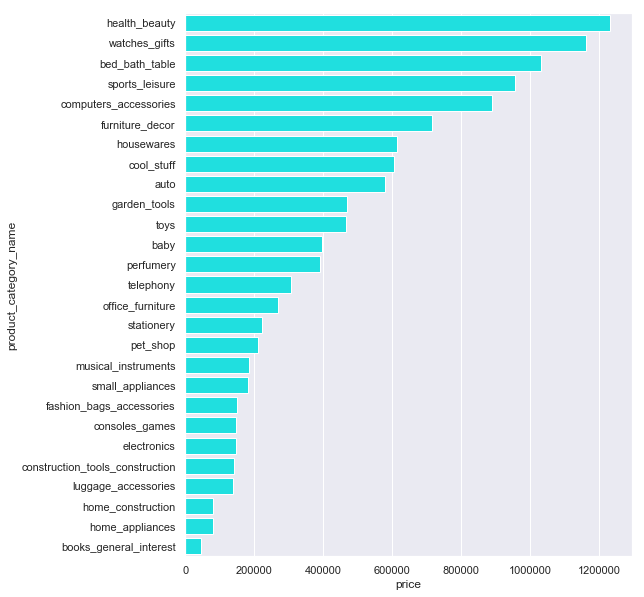

In [52]:
plot_filtered_groupby(customers, 'product_category_name', 'price', 500, sum)

> It looks like heath and beauty, watches, bed and bath, sports leisure and computer accessories round out the top 5 most profittable product categories. Does this correlate the the price or simply the populatiry of the items? 

### Which product has the highest average cost for the customer?

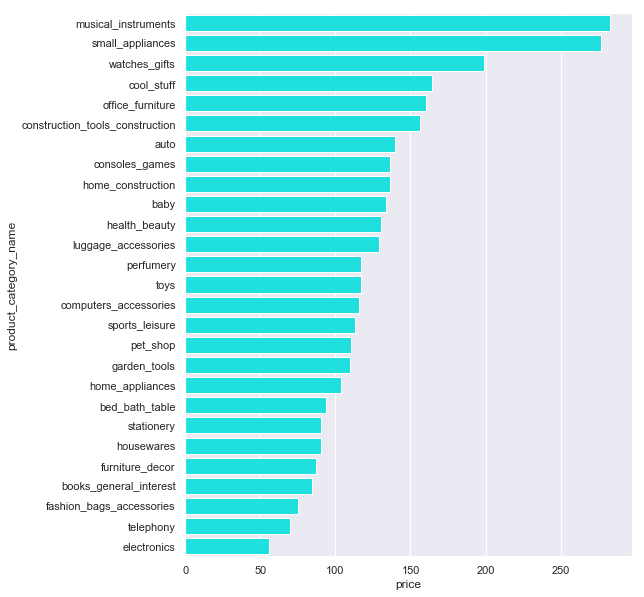

In [53]:
plot_filtered_groupby(customers, 'product_category_name', 'price', 500, np.mean)

> The top 5 highest average cost product categories do not overlap with the highest profit categories. Falling just out of the top 5 average cost products is watches. This is an important product to maintain customer satisfaction for by possibly prioritizing on time deliveries. 

### What are the highest rated products?

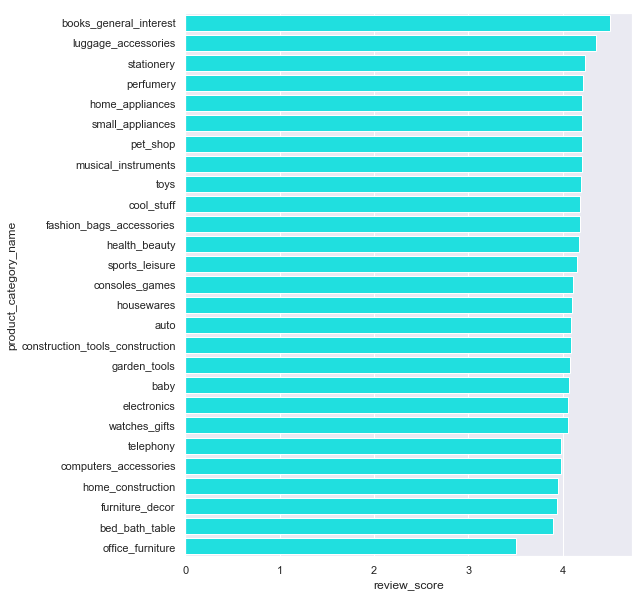

In [54]:
plot_filtered_groupby(customers, 'product_category_name', 'review_score', 500, np.mean)

> It looks like many of the highest grossing products fall on the lower end of the average review score with the exception of health and beauty, and sports leisure. 

### Which products are purchased most frequently?

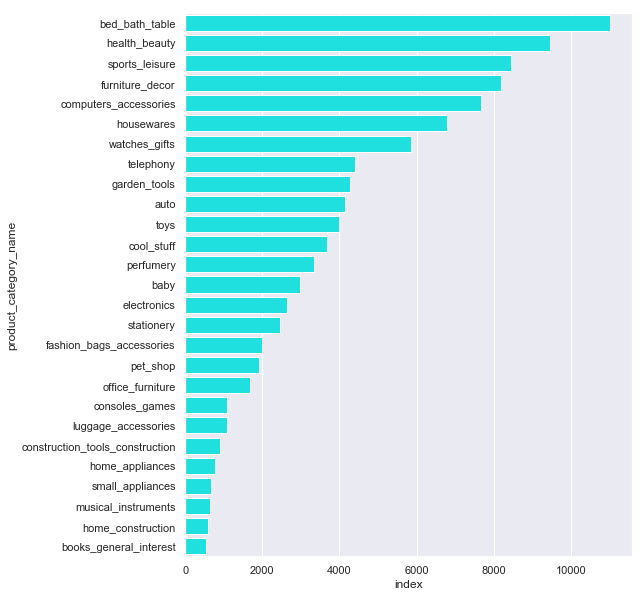

In [55]:
df_filtered = filter_by_count(customers, 'product_category_name', 500)['product_category_name'].reset_index()
    
df_agg = df_filtered.groupby(['product_category_name'])\
                              .count().sort_values(['index'], ascending = False)\
                              .reset_index()

fig, ax = plt.subplots(figsize=(8, 10))
    
ax = sns.barplot(data=df_agg, x='index', y='product_category_name', color = 'cyan')
plt.show()

## Exploring Seasonal Trends

### When is Olist receiving the most profit?

In [56]:
def timeseries_plot(df, timeseries_col, y_col, agg_func, dStart, dEnd, sample_by = 'D'):
    
    timeseries_vs_y = df[[timeseries_col, y_col]]
    plot_df = timeseries_vs_y.set_index(timeseries_col).resample(sample_by)[y_col].apply(agg_func)
    df = plot_df[(dStart <= plot_df.index) & (plot_df.index <= dEnd)]

    ax = plt.figure(figsize=(12, 6)).add_subplot(111)   
    xticks = pd.date_range(start=dStart, end=dEnd, freq='M')

    df.plot(ax = ax, xticks = xticks)

    ax.set_xticklabels([x.strftime('%h\n%Y') for x in xticks])
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right')

    plt.show()

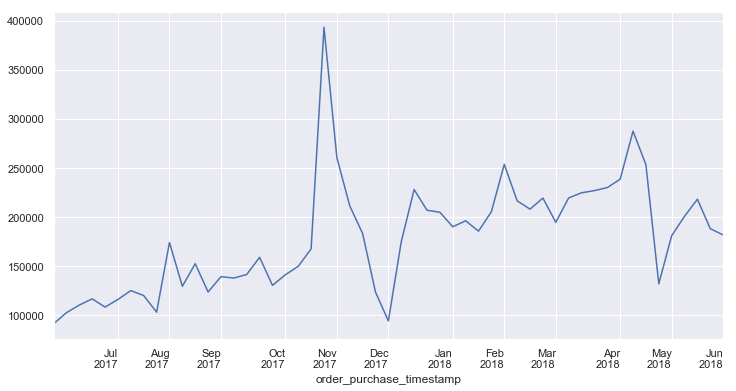

In [57]:
# Total profit over 
dStart = datetime.datetime(2017,7,1) # 1 May
dEnd = datetime.datetime(2018,7,1) # 1 July
timeseries_plot(customers, 'order_purchase_timestamp', 'price', sum, dStart, dEnd, 'W')

> There is an uptick in profit in late November, most definitely corresponding to gifts for the Christmas season. There are local peaks at the end of February and the beginning of May as well with sharp drops in profit near January 1st and towards the end of May. In Brazil, the well known Carnival festival falls towards the end of February, possibly corresponding to the increase in profit. It is not clear why there is such a sharp increase in profit in early May. This is something to continue investigating. 

### How do review scores change over time? Are there connections to national holidays?

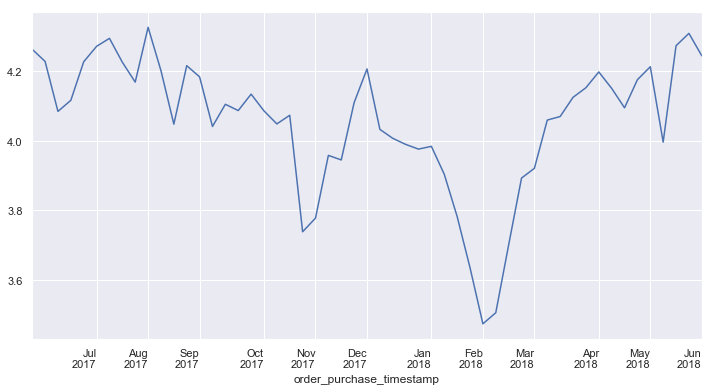

In [58]:
timeseries_plot(customers, 'order_purchase_timestamp', 'review_score', np.mean, dStart, dEnd, 'W')

> The average review score drops during high volume purchasing periods. We see a drop as shoppers buy for Christmas and a sharp drop in late february, corresponding to the increase in sales observed in the previous graph. The peak in profits around early May do not produce as sharp of a drop as during the two aforementioned periods but there is still an occurance. 

### When do customers write the most reviews?

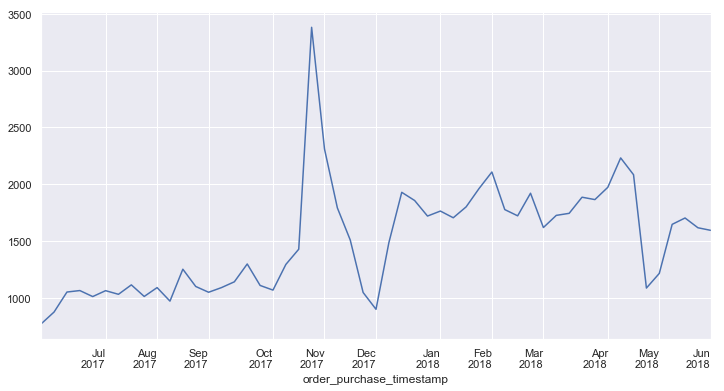

In [59]:
timeseries_vs_y = customers[['order_purchase_timestamp', 'review_comment_message']]
plot_df = timeseries_vs_y.set_index('order_purchase_timestamp').resample('W')['review_comment_message'].count()
#dStart = datetime.datetime(2017,1,1) # 1 May
#dEnd = datetime.datetime(2018,8,29) # 1 July
df = plot_df[(dStart <= plot_df.index) & (plot_df.index <= dEnd)]

ax = plt.figure(figsize=(12, 6)).add_subplot(111)   
xticks = pd.date_range(start=dStart, end=dEnd, freq='M')

df.plot(ax = ax, xticks = xticks)

ax.set_xticklabels([x.strftime('%h\n%Y') for x in xticks])
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')

plt.show()


> Not suprisingly, the most reviews occur prior to the Christmas holiday with two other peaks related to the peak periods observed previously. 

### During what seasons are late delivery times the most significant?

In [60]:
#customers[customers['order_delivered_customer_date'] > customers['order_estimated_delivery_date']].count()
delivery_time = customers[['order_delivered_customer_date', 'order_estimated_delivery_date', 
                           'review_score', 'order_purchase_timestamp']]
delivery_time['on_time'] = (delivery_time['order_estimated_delivery_date']
                           >=
                           delivery_time['order_delivered_customer_date'])

delivery_time['diff_days'] = (delivery_time['order_delivered_customer_date']
                             -
                             delivery_time['order_estimated_delivery_date'])

delivery_time['diff_days'] = delivery_time['diff_days']/np.timedelta64(1, 'D')
delivery_time['satisfied'] = (delivery_time['review_score'] >= 3)

In [61]:
late_deliveries = delivery_time.loc[delivery_time['on_time'] == False]

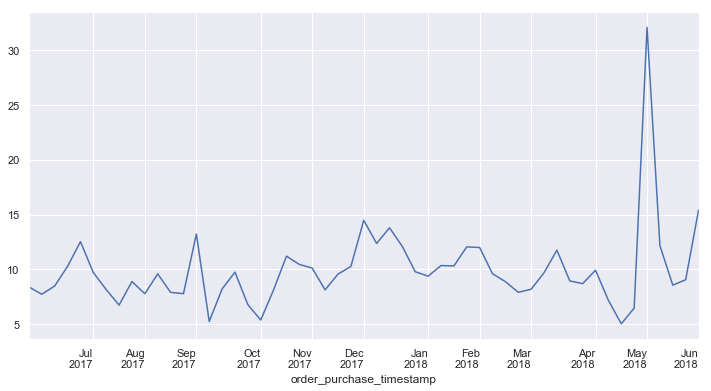

In [62]:
dStart = datetime.datetime(2017,7,1) # 1 May
dEnd = datetime.datetime(2018,7,1) # 1 July
timeseries_plot(late_deliveries, 'order_purchase_timestamp', 'diff_days', np.mean, dStart, dEnd, 'W')

> We see that the average lateness slightly increases relative to the high volume periods but more suprisingly there are larger differences seen during low volume periods. For example, there is a peak around January 1st, when sales dip dramatically. There is also a sharp increase at the end of May, around the same time there is a significant dip in profit. There is a possiblity that late delivery outliers could be pulling the average up for those low volume periods however.

### When are people most satisfied with their experience? How well does this correlate to on time deliveries?

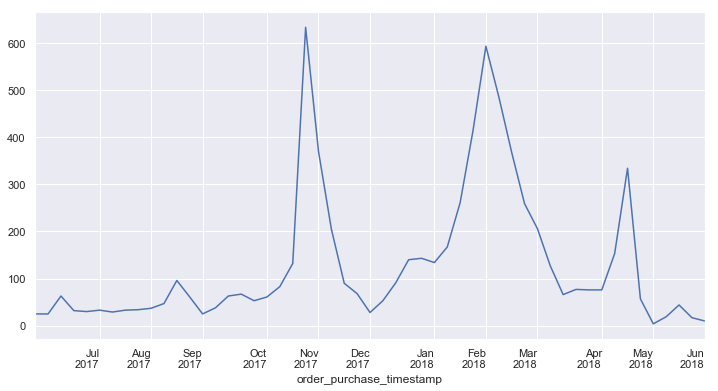

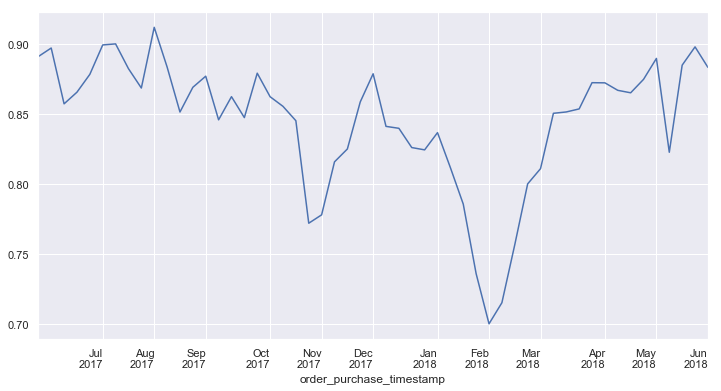

In [63]:
import matplotlib.dates as mdates
import datetime


plot1_df = late_deliveries.set_index('order_purchase_timestamp').resample('W')['on_time'].count()
plot2_df = delivery_time.set_index('order_purchase_timestamp').resample('W')['satisfied'].apply(np.mean)
dStart = datetime.datetime(2017,7,1) # 1 May
dEnd = datetime.datetime(2018,7,1) # 1 July
df1 = plot1_df[(dStart <= plot1_df.index) & (plot1_df.index <= dEnd)]
df2 = plot2_df[(dStart <= plot2_df.index) & (plot2_df.index <= dEnd)]

ax = plt.figure(figsize=(12, 6)).add_subplot(111)
ax2 = plt.figure(figsize=(12, 6)).add_subplot(111)
xticks = pd.date_range(start=dStart, end=dEnd, freq='M')

df1.plot(ax = ax, xticks = xticks)
df2.plot(ax = ax2, xticks = xticks)

ax.set_xticklabels([x.strftime('%h\n%Y') for x in xticks])
ax2.set_xticklabels([x.strftime('%h\n%Y') for x in xticks])
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.setp(ax2.xaxis.get_majorticklabels(), ha='right')

plt.show()

> There is clearly a relationship between customer satisfaction and on-time delivery. The number of satisfied customers dip dramatically for the three main high volume periods.

## Recommender system using LightFM

### Create user-item and item feature dataframes

In [64]:
customers.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'geolocation_lat', 'geolocation_lng', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm'],
      dtype='object')

In [65]:
user_item = customers[['customer_id', 'customer_unique_id', 'product_id', 'review_score', 'order_purchase_timestamp']]
item_features = customers[['customer_unique_id','product_id', 'product_category_name', 'seller_id', 'review_score', 
                          'review_comment_message']]

In [66]:
# to avoid counting a review comment labeled 'no comment given', we will convert them back to NAN
item_features['review_comment_message'] = item_features.review_comment_message\
                                                               .replace('no comment given', np.nan)

# create average review score column 
item_features['avg_product_score'] = item_features['review_score']\
                                                                 .groupby(item_features['product_id'])\
                                                                 .transform('mean')
# create average review score column 
item_features['avg_seller_score'] = item_features['review_score']\
                                                                 .groupby(item_features['seller_id'])\
                                                                 .transform('mean')

# create average review score column 
item_features['num_comments'] = item_features['review_comment_message']\
                                                                       .groupby(item_features['product_id'])\
                                                                       .transform('count')

# create average review score column 
item_features['num_reviews'] = item_features['review_score']\
                                                            .groupby(item_features['product_id'])\
                                                            .transform('count')

In [67]:
# Create product_count column for the rating
item_features['product_count'] = item_features['product_id']\
                                                            .groupby(item_features['customer_unique_id'])\
                                                            .transform('count')

In [68]:
item_features['log_num_reviews'] = np.log1p(item_features['num_reviews'])
item_features['log_num_comments'] = np.log1p(item_features['num_comments'])

In [69]:
# use cut to group the same number of reviews in each section
item_features['num_reviews_binned'] = pd.cut(item_features['log_num_reviews'], 7, duplicates = 'drop')
item_features['num_comments_binned'] = pd.cut(item_features['log_num_comments'], 6, duplicates = 'drop')

# 
item_features['avg_product_reviews_binned'] = pd.cut(item_features['avg_product_score'], 4, duplicates = 'drop')
item_features['avg_seller_reviews_binned'] = pd.cut(item_features['avg_seller_score'], 4, duplicates = 'drop')

In [194]:
cols = ['num_reviews_binned', 'num_comments_binned','avg_product_reviews_binned', 'avg_seller_reviews_binned']
for col in cols:
    item_features[col] = item_features[col].astype(str)

In [195]:
item_features.columns

Index(['customer_unique_id', 'product_id', 'product_category_name',
       'seller_id', 'review_score', 'review_comment_message',
       'avg_product_score', 'avg_seller_score', 'num_comments', 'num_reviews',
       'product_count', 'log_num_reviews', 'log_num_comments',
       'num_reviews_binned', 'num_comments_binned',
       'avg_product_reviews_binned', 'avg_seller_reviews_binned'],
      dtype='object')

In [196]:
def get_user_list(df, user_column):
    """
    
    creating a list of user from dataframe df, user_column is a column 
    consisting of users in the dataframe df
    
    """
    
    return np.sort(df[user_column].unique())

def get_item_list(df, item_name_column):
    
    """
    
    creating a list of items from dataframe df, item_column is a column 
    consisting of items in the dataframe df
    
    return to item_id_list and item_id2name_mapping
    
    """
    
    item_list = df[item_name_column].unique()
    
    
    return item_list

def get_feature_list(df, product_category_col, seller_col, seller_rating_col, product_rating_col, num_comments, num_reviews):
    
    categories = df[product_category_col]
    sellers = df[seller_col]
    seller_ratings = df[seller_rating_col]
    product_ratings = df[product_rating_col]
    num_product_comments = df[num_comments]
    num_product_reviews = df[num_reviews]
    
    return pd.concat([categories, sellers, seller_ratings, product_ratings, num_product_comments, num_product_reviews], ignore_index = True).unique()

In [197]:
# create the user, item, feature lists
users = get_user_list(user_item, "customer_unique_id")
items = get_item_list(item_features, "product_id")
features = get_feature_list(item_features, "product_category_name", "seller_id", "avg_seller_reviews_binned",
                           "avg_product_reviews_binned", "num_comments_binned", "num_reviews_binned")

In [198]:
def id_mappings(user_list, item_list, feature_list):
    """
    
    Create id mappings to convert user_id, item_id, and feature_id
    
    """
    user_to_index_mapping = {}
    index_to_user_mapping = {}
    for user_index, user_id in enumerate(user_list):
        user_to_index_mapping[user_id] = user_index
        index_to_user_mapping[user_index] = user_id
        
    item_to_index_mapping = {}
    index_to_item_mapping = {}
    for item_index, item_id in enumerate(item_list):
        item_to_index_mapping[item_id] = item_index
        index_to_item_mapping[item_index] = item_id
        
    feature_to_index_mapping = {}
    index_to_feature_mapping = {}
    for feature_index, feature_id in enumerate(feature_list):
        feature_to_index_mapping[feature_id] = feature_index
        index_to_feature_mapping[feature_index] = feature_id
        
        
    return user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping, \
           feature_to_index_mapping, index_to_feature_mapping

In [199]:
# generate mapping, LightFM library can't read other than (integer) index
user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping, \
           feature_to_index_mapping, index_to_feature_mapping = id_mappings(users, items, features)

In [200]:
product_to_feature = item_features[['product_id', 'product_category_name', 'seller_id', 'num_reviews_binned', 
                                    'num_comments_binned', 'avg_product_reviews_binned', 'avg_seller_reviews_binned']]

In [201]:
user_to_product_rating = item_features[['customer_unique_id', 'product_id', 'product_count']]

In [202]:
user_to_product_rating = user_to_product_rating.sort_values(by='customer_unique_id').reset_index(drop=True)

In [203]:
import random
np.random.seed(31)

rows = np.random.binomial(1, .8, size=len(user_to_product_rating)).astype('bool')

user_to_product_rating_train = user_to_product_rating[rows].reset_index(drop=True)
user_to_product_rating_test = user_to_product_rating[~rows].reset_index(drop=True)

In [204]:
product_to_feature = product_to_feature.drop_duplicates('product_id').reset_index(drop=True)

In [205]:
# Transpose product_to_feature to extract features for each product_id
df = product_to_feature.set_index('product_id').T.reset_index(drop=True)

In [206]:
# Need to create list of product_id's repeated 6 times for each feauture the resulting df will hold
cols = list(df.columns)
res =  [ele for ele in cols for i in range(6)]

In [207]:
# Create empty dataframe with index as product_id
features = pd.DataFrame(index = res)
features.index.name = 'product_id'

# Reset index so 'product_id' becomes column
features = features.reset_index()

# create empty column to fill
features['feature'] = ""

In [208]:
# Create list of feature items to replace empty column
feature_items = []
for col in cols:
    for i in range(6):
        feature_items.append(df[col][i])

In [209]:
features['feature'] = feature_items

In [210]:
product_to_feature = features

In [211]:
product_to_feature['feature_count'] = 1

In [287]:
product_to_feature.head()

,product_id,feature,feature_count
0,87285b34884572647811a353c7ac498a,housewares,1
1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,1
2,87285b34884572647811a353c7ac498a,"(1.487, 2.281]",1
3,87285b34884572647811a353c7ac498a,"(0.913, 1.825]",1
4,87285b34884572647811a353c7ac498a,"(3.0, 4.0]",1


In [286]:
user_to_product_rating_train.head()

,customer_unique_id,product_id,product_count
0,0000366f3b9a7992bf8c76cfdf3221e2,372645c7439f9661fbbacfd129aa92ec,1
1,0000f46a3911fa3c0805444483337064,64b488de448a5324c4134ea39c28a34b,1
2,0004aac84e0df4da2b147fca70cf8255,c72e18b3fe2739b8d24ebf3102450f37,1
3,0004bd2a26a76fe21f786e4fbd80607f,25cf184645f3fae66083bf33581b8f13,1
4,00053a61a98854899e70ed204dd4bafe,58727e154e8e85d84052cd22b0136c84,2


In [276]:
user_to_product_rating_test.head()

,customer_unique_id,product_id,product_count
0,0000b849f77a49e4a4ce2b2a4ca5be3f,5099f7000472b634fea8304448d20825,1
1,0000f6ccb0745a6a4b88665a16c9f078,2345a354a6f2033609bbf62bf5be9ef6,1
2,00050ab1314c0e55a6ca13cf7181fecf,8cefe1c6f2304e7e6825150218ffc58c,1
3,000d460961d6dbfa3ec6c9f5805769e1,53075a78fc601d6eb47e8ad2d142b7a8,1
4,000ec5bff359e1c0ad76a81a45cb598f,e9aa3fd3f316b44c85f671552a04fa4a,1


In [215]:
from scipy import sparse
def get_interaction_matrix(df, df_column_as_row, df_column_as_col, df_column_as_value, row_indexing_map, 
                          col_indexing_map):
    
    row = df[df_column_as_row].apply(lambda x: row_indexing_map[x]).values
    col = df[df_column_as_col].apply(lambda x: col_indexing_map[x]).values
    value = df[df_column_as_value].values
    
    return sparse.coo_matrix((value, (row, col)), shape = (len(row_indexing_map), len(col_indexing_map)))

In [216]:

# generate user_item_interaction_matrix for train data
user_to_product_interaction_train = get_interaction_matrix(user_to_product_rating_train, "customer_unique_id", 
                                                    "product_id", "product_count", user_to_index_mapping, item_to_index_mapping)

# generate user_item_interaction_matrix for test data
user_to_product_interaction_test = get_interaction_matrix(user_to_product_rating_test, "customer_unique_id", 
                                                    "product_id", "product_count", user_to_index_mapping, item_to_index_mapping)

# generate item_to_feature interaction
product_to_feature_interaction = get_interaction_matrix(product_to_feature, "product_id", "feature",  "feature_count", 
                                                        item_to_index_mapping, feature_to_index_mapping)

In [221]:
# initialising model with warp loss function
model_without_features = LightFM(loss = "warp")

# fitting into user to product interaction matrix only / pure collaborative filtering factor
start = time.time()
#===================

model_without_features.fit(user_to_product_interaction_train,
          user_features=None, 
          item_features=None, 
          sample_weight=None, 
          epochs=1, 
          num_threads=4,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

# auc metric score (ranging from 0 to 1)

start = time.time()
#===================

auc_without_features = auc_score(model = model_without_features, 
                        test_interactions = user_to_product_interaction_test,
                        num_threads = 4, check_intersections = False)
#===================
end = time.time()

print("time taken = {0:.{1}f} seconds".format(end - start, 2))
print("average AUC without adding item-feature interaction = {0:.{1}f}".format(auc_without_features.mean(), 2))

time taken = 0.16 seconds
time taken = 22.43 seconds
average AUC without adding item-feature interaction = 0.68


In [222]:
import time
from lightfm import LightFM
from lightfm.evaluation import auc_score
# initialising model with warp loss function
model_with_features = LightFM(loss = "warp")

# fitting the model with hybrid collaborative filtering + content based (product + features)
start = time.time()
#===================


model_with_features.fit(user_to_product_interaction_train,
          user_features=None, 
          item_features=product_to_feature_interaction, 
          sample_weight=None, 
          epochs=1, 
          num_threads=4,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

start = time.time()
#===================
auc_with_features = auc_score(model = model_with_features, 
                        test_interactions = user_to_product_interaction_test,
                        train_interactions = user_to_product_interaction_train, 
                        item_features = product_to_feature_interaction,
                        num_threads = 4, check_intersections=False)
#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

print("average AUC with adding item-feature interaction = {0:.{1}f}".format(auc_with_features.mean(), 2))


time taken = 0.21 seconds
time taken = 45.75 seconds
average AUC with adding item-feature interaction = 0.79


In [225]:
def combined_train_test(train, test):
    """
    
    test set is the more recent rating/number_of_order of users.
    train set is the previous rating/number_of_order of users.
    non-zero value in the test set will replace the elements in 
    the train set matrices
    """
    # initialising train dict
    train_dict = {}
    for train_row, train_col, train_data in zip(train.row, train.col, train.data):
        train_dict[(train_row, train_col)] = train_data
        
    # replacing with the test set
    
    for test_row, test_col, test_data in zip(test.row, test.col, test.data):
        train_dict[(test_row, test_col)] = max(test_data, train_dict.get((test_row, test_col), 0))
        
    
    # converting to the row
    row_element = []
    col_element = []
    data_element = []
    for row, col in train_dict:
        row_element.append(row)
        col_element.append(col)
        data_element.append(train_dict[(row, col)])
        
    # converting to np array
    
    row_element = np.array(row_element)
    col_element = np.array(col_element)
    data_element = np.array(data_element)
    
    return sparse.coo_matrix((data_element, (row_element, col_element)), shape = (train.shape[0], train.shape[1]))

In [226]:
user_to_product_interaction = combined_train_test(user_to_product_interaction_train, 
                                                 user_to_product_interaction_test)

In [256]:
# retraining the final model with combined dataset

final_model = LightFM(loss = "warp")

# fitting to combined dataset with pure collaborative filtering result

start = time.time()
#===================

final_model.fit(user_to_product_interaction,
          user_features=None, 
          item_features=product_to_feature_interaction, 
          sample_weight=None, 
          epochs=1, 
          num_threads=4,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 0.26 seconds


In [258]:
class recommendation_sampling:
    
    def __init__(self, model, items = items, user_to_product_interaction_matrix = user_to_product_interaction, 
                user2index_map = user_to_index_mapping):
        
        self.user_to_product_interaction_matrix = user_to_product_interaction_matrix
        self.model = model
        self.items = items
        self.user2index_map = user2index_map
    
    def recommendation_for_user(self, user):
        
        # getting the userindex
        
        userindex = self.user2index_map.get(user, None)
        
        if userindex == None:
            return None
        
        users = [userindex]
        
        # products already bought
        
        known_positives = self.items[self.user_to_product_interaction_matrix.tocsr()[userindex].indices]
        
        # scores from model prediction
        scores = self.model.predict(user_ids = users, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1]),
                                    item_features = product_to_feature_interaction)
        
        # top items
        
        top_items = self.items[np.argsort(-scores)]
        
        # printing out the result
        print("User %s" % user)
        print("     Known positives:")
        
        for x in known_positives[:3]:
            print("                  %s" % x)
            print("                  {}".format(product_to_feature['feature'][product_to_feature['product_id'] == x].iloc[0]))
            
            
        print("     Recommended:")
        
        for x in top_items[:3]:
            print("                  %s" % x)
            print("                  {}".format(product_to_feature['feature'][product_to_feature['product_id'] == x].iloc[0]))

In [291]:
recom = recommendation_sampling(model = final_model)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('11f97da02237a49c8e783dfda6f50e8e'))

User 11f97da02237a49c8e783dfda6f50e8e
     Known positives:
                  37eb69aca8718e843d897aa7b82f462d
                  garden_tools
     Recommended:
                  2b4609f8948be18874494203496bc318
                  health_beauty
                  154e7e31ebfa092203795c972e5804a6
                  health_beauty
                  389d119b48cf3043d311335e499d9c6b
                  garden_tools
None


- drop products that havent been bought too many times
- 


## Recommender System using LightFM

### Data preprocessing:

**Metadata:**

We want to begin by extracting information about each product with at least one review. More general information will also be required about each product, such as the average review score, the number of messages and number of reviews. This will be done by pulling columns from the cleaned sellers df created in the data cleaning section of this report.

Following this we will group the product descriptions into bins to generalize for the model using pandas cut and qcut.

In [ ]:
sellers.columns

In [ ]:
def create_interaction_matrix(df,user_col, item_col, rating_col, norm= False, threshold = None):
    '''
    Function to create an interaction matrix dataframe from transactional type interactions
    Required Input -
        - df = Pandas DataFrame containing user-item interactions
        - user_col = column name containing user's identifier
        - item_col = column name containing item's identifier
        - rating col = column name containing user feedback on interaction with a given item
        - norm (optional) = True if a normalization of ratings is needed
        - threshold (required if norm = True) = value above which the rating is favorable
    Expected output - 
        - Pandas dataframe with user-item interactions ready to be fed in a recommendation algorithm
    '''
    interactions = df.groupby([user_col, item_col])[rating_col] \
            .sum().unstack().reset_index(). \
            fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

In [ ]:
# Creating interaction matrix using rating data
interactions = create_interaction_matrix(df = ratings_selected,
                                         user_col = 'customer_id',
                                         item_col = 'product_id',
                                         rating_col = 'review_score',
                                         norm=True,
                                         threshold=3)
interactions.head()

In [ ]:
def create_item_dict(df,id_col,name_col):
    '''
    Function to create an item dictionary based on their item_id and item name
    Required Input - 
        - df = Pandas dataframe with Item information
        - id_col = Column name containing unique identifier for an item
        - name_col = Column name containing name of the item
    Expected Output -
        item_dict = Dictionary type output containing item_id as key and item_name as value
    '''
    item_dict ={}
    for i in range(df.shape[0]):
        item_dict[(df.loc[i,id_col])] = df.loc[i,name_col]
    return item_dict

In [ ]:
def create_user_dict(interactions):
    '''
    Function to create a user dictionary based on their index and number in interaction dataset
    Required Input - 
        interactions - dataset create by create_interaction_matrix
    Expected Output -
        user_dict - Dictionary type output containing interaction_index as key and user_id as value
    '''
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

In [ ]:
# Create User Dict
user_dict = create_user_dict(interactions=interactions)
# Create Item dict
items_dict = create_item_dict(df = items_selected,
                               id_col = 'product_id',
                               name_col = 'product_category_name')

In [ ]:
def runMF(interactions, n_components=30, loss='warp', k=15, epoch=30,n_jobs = 4):
    '''
    Function to run matrix-factorization algorithm
    Required Input -
        - interactions = dataset create by create_interaction_matrix
        - n_components = number of embeddings you want to create to define Item and user
        - loss = loss function other options are logistic, brp
        - epoch = number of epochs to run 
        - n_jobs = number of cores used for execution 
    Expected Output  -
        Model - Trained model
    '''
    x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components= n_components, loss=loss,k=k)
    model.fit(x,epochs=epoch,num_threads = n_jobs)
    return model

In [ ]:
from lightfm import LightFM
from scipy import sparse
mf_model = runMF(interactions = interactions,
                 n_components = 150,
                 loss = 'warp',
                 epoch = 30,
                 n_jobs = 4)

In [ ]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    '''
    Function to produce user recommendations
    Required Input - 
        - model = Trained matrix factorization model
        - interactions = dataset used for training the model
        - user_id = user ID for which we need to generate recommendation
        - user_dict = Dictionary type input containing interaction_index as key and user_id as value
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - threshold = value above which the rating is favorable in new interaction matrix
        - nrec_items = Number of output recommendation needed
    Expected Output - 
        - Prints list of items the given user has already bought
        - Prints list of N recommended items  which user hopefully will be interested in
    '''
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index) \
                                 .sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
    return return_score_list

In [ ]:
sample_recommendation_user(model = mf_model, 
                                      interactions = interactions, 
                                      user_id = 'fc3d1daec319d62d49bfb5e1f83123e9', 
                                      user_dict = user_dict,
                                      item_dict = items_dict, 
                                      threshold = 4,
                                      nrec_items = 5,
                                      show = True)

## Train, Test, Split Refactored

In [ ]:
import random
np.random.seed(31)

rows = np.random.binomial(1, .5, size=len(ratings_)).astype('bool')

ratings_train = ratings_[rows].reset_index(drop=True)
ratings_test = ratings_[~rows].reset_index(drop=True)

items_train = items_[rows].reset_index(drop=True)
items_test = items_[~rows].reset_index(drop=True)

In [ ]:
ratings_train.head()

In [ ]:
# Creating interaction matrix using rating data
interactions_train = create_interaction_matrix(df = ratings_train,
                                             user_col = 'customer_id',
                                             item_col = 'product_id',
                                             rating_col = 'review_score',
                                             norm=True,
                                             threshold=3)

In [ ]:
interactions_train.head()

In [ ]:
# Creating interaction matrix using rating data
interactions_test = create_interaction_matrix(df = ratings_test,
                                             user_col = 'customer_id',
                                             item_col = 'product_id',
                                             rating_col = 'review_score',
                                             norm=True,
                                             threshold=3)
interactions_test.head()

In [ ]:
# Create User Dict
user_dict_train = create_user_dict(interactions=interactions_train)
# Create Item dict
items_dict_train = create_item_dict(df = items_train,
                               id_col = 'product_id',
                               name_col = 'product_category_name')

In [ ]:
# Create User Dict
user_dict_train = create_user_dict(interactions=interactions_test)
# Create Item dict
items_dict_train = create_item_dict(df = items_test,
                               id_col = 'product_id',
                               name_col = 'product_category_name')

In [ ]:
import itertools

import numpy as np

from lightfm import LightFM
from lightfm.evaluation import auc_score


def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """

    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }


def random_search(test, train, num_samples=10, num_threads=1):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.

    Parameters
    ----------

    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.


    Returns
    -------

    generator of (auc_score, hyperparameter dict, fitted model)

    """

    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train, epochs=num_epochs, num_threads=num_threads)

        score = auc_score(model, 
                          test_interactions=test,
                          num_threads=num_threads).mean()

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)

In [ ]:
from scipy import sparse
if __name__ == "__main__":
    
    #user_features = customer_product_interaction_test.index
    #item_features = customer_product_interaction_test.columns
    
    x_test = sparse.csr_matrix(interactions_test.values)
    x_train = sparse.csr_matrix(interactions_train.values)
    
    (score, hyperparams, model) = max(random_search(x_test, x_train),
                                      key=lambda x: x[0])
    
    
    print("Best score {} at {}".format(score, hyperparams))

In [ ]:
# product info, will use review score and review comments to create aggregated columns
metadata_selected = customers[['customer_id', 'product_id', 'seller_id', 'product_category_name', 'product_name_lenght',
                             'product_description_lenght', 'product_photos_qty', 'product_weight_g',
                             'product_length_cm', 'product_height_cm', 'product_width_cm', 'review_score', 
                             'review_comment_message', 'review_answer_timestamp']]
metadata_selected.sort_values('product_id', ascending=False, inplace=True)
metadata_selected.reset_index(drop=True, inplace=True)

In [ ]:
metadata_selected.head()

In [ ]:
interactions = customers[['customer_id', 'product_id', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date', 'review_answer_timestamp']]
interactions.sort_values('product_id', ascending=False, inplace=True)
interactions.reset_index(drop=True, inplace=True)

In [ ]:
# set dfs to have common orders between them
metadata_selected = metadata_selected[metadata_selected.product_id.isin(interactions.product_id)].reset_index(drop=True)
interactions = interactions[interactions.product_id.isin(metadata_selected.product_id)].reset_index(drop=True)

In [ ]:
ratings_ = metadata_selected[['customer_id', 'product_id', 'review_score', 'review_answer_timestamp']]
items_ = metadata_selected[['product_id', 'product_category_name']]

## Work using LightFM Documentation

In [ ]:
import random
np.random.seed(31)

rows = np.random.binomial(1, .75, size=len(ratings_)).astype('bool')

ratings_train = ratings_[rows].reset_index(drop=True)
ratings_test = ratings_[~rows].reset_index(drop=True)

items_train = items_[rows].reset_index(drop=True)
items_test = items_[~rows].reset_index(drop=True)

In [ ]:
from lightfm.data import Dataset
dataset = Dataset()
dataset.fit(
            (x['customer_id'] for x in ratings_train[['customer_id', 'product_id', 'review_score']]),
            (x['product_id'] for x in  items_train[['product_id', 'product_category_name']])
            )

In [ ]:
dataset = Dataset()
dataset.fit((x['User-ID'] for x in get_ratings()),
            (x['ISBN'] for x in get_ratings()))

In [ ]:
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

In [ ]:
(interactions, weights) = dataset.build_interactions(zip(ratings_train['customer_id'], ratings_train['product_id']))

In [ ]:
print(repr(interactions))

In [ ]:
item_features = dataset_.build_item_features(zip(items_train['product_id'], items_train['product_category_name']))
print(repr(item_features))

# Prior work

In [ ]:
# to avoid counting a review comment labeled 'no comment given', we will convert them back to NAN
metadata_selected['review_comment_message'] = metadata_selected.review_comment_message\
                                                               .replace('no comment given', np.nan)

# create average review score column 
metadata_selected['avg_review_score'] = metadata_selected['review_score']\
                                                                         .groupby(metadata_selected['product_id'])\
                                                                         .transform('mean')
# total up reviews per product_id
metadata_selected['num_reviews'] = metadata_selected['review_score']\
                                                                    .groupby(metadata_selected['product_id'])\
                                                                    .transform('count')

# total up comments per product_id
metadata_selected['num_comments'] = metadata_selected['review_comment_message']\
                                                           .groupby(metadata_selected['product_id'])\
                                                           .transform('count')

In [ ]:
# round avg_review_score to the nearest .5
metadata_selected['avg_review_score'] = metadata_selected['avg_review_score'].apply(lambda x: round(x*2)/2)

# use cut to define bin edges
cols_to_cut = ['product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm']
for col in cols_to_cut:
    metadata_selected[col] = pd.cut(metadata_selected[col], bins = 25)

# use qcut to group the same number of reviews in each section
metadata_selected['num_reviews'] = pd.qcut(metadata_selected['num_reviews'], 25, duplicates = 'drop')
metadata_selected['num_comments'] = pd.qcut(metadata_selected['num_comments'], 10, duplicates = 'drop')

In [ ]:
metadata_selected.head()

In [ ]:
interactions.head()

__Train, test split__

In [ ]:
import random
np.random.seed(31)

rows = np.random.binomial(1, .8, size=len(interactions)).astype('bool')

metadata_train = metadata_selected[rows]
metadata_test = metadata_selected[~rows]

interactions_train = interactions[rows]
interactions_test = interactions[~rows]

In [ ]:
metadata_train.head()

In [ ]:
interactions_train.head()

__Prepare train and test__

__Customer-product interactions df:__

We want to now create a dataframe that describes the relationship between customer and product including review scores and comments. 

In [ ]:
# select reviews for each product and drop duplicate rows
interactions_train_selected = metadata_train[['customer_id', 'product_id', 'review_score']]
#interactions_train_selected.drop_duplicates(keep = 'first', inplace=True)

interactions_test_selected = metadata_test[['customer_id', 'product_id', 'review_score']]
#interactions_test_selected.drop_duplicates(keep = 'first', inplace=True)

__Create dummy variables__

In [ ]:
# Train
# dummify groupings
cols_to_dummify = ['product_category_name','product_name_lenght', 'product_description_lenght',
                   'product_photos_qty', 'product_weight_g', 'product_length_cm',
                   'product_height_cm', 'product_width_cm', 'avg_review_score',
                   'num_reviews', 'num_comments']
products_metadata_train_transformed = pd.get_dummies(metadata_train, 
                                                        columns = cols_to_dummify)

# sort the rows by product and reset the index
products_metadata_train_transformed = products_metadata_train_transformed\
                                                                         .sort_values('product_id')\
                                                                         .reset_index()\
                                                                         .drop('index', axis=1)

In [ ]:
# set the index as product_id
products_metadata_train_transformed_ = products_metadata_train_transformed.set_index('product_id')
products_features_train_transformed = products_metadata_train_transformed_.drop(['seller_id', 'customer_id'], axis=1)

# set the index as product_id
customers_metadata_train_transformed = products_metadata_train_transformed.set_index('customer_id')
customers_features_train_transformed = customers_metadata_train_transformed.drop(['seller_id', 'product_id'], axis=1)

In [ ]:
products_features_train_transformed.drop(['review_comment_message', 'review_score'], axis=1, inplace=True)
customers_features_train_transformed.drop(['review_comment_message', 'review_score'], axis=1, inplace=True)

In [ ]:
# Test
# dummify groupings
cols_to_dummify = ['product_category_name','product_name_lenght', 'product_description_lenght',
                   'product_photos_qty', 'product_weight_g', 'product_length_cm',
                   'product_height_cm', 'product_width_cm', 'avg_review_score',
                   'num_reviews', 'num_comments']
products_metadata_test_transformed = pd.get_dummies(metadata_test, 
                                                        columns = cols_to_dummify)

# sort the rows by product and reset the index
products_metadata_test_transformed = products_metadata_test_transformed\
                                                                        .sort_values('product_id')\
                                                                        .reset_index()\
                                                                        .drop('index', axis=1)

In [ ]:
# set the index as product_id
products_metadata_test_transformed_ = products_metadata_test_transformed.set_index('product_id')
products_features_test_transformed = products_metadata_test_transformed_.drop(['seller_id', 'customer_id'], axis=1)

# set the index as product_id
customers_metadata_test_transformed = products_metadata_test_transformed.set_index('customer_id')
customers_features_test_transformed = customers_metadata_test_transformed.drop(['seller_id', 'product_id'], axis=1)

In [ ]:
products_features_test_transformed.drop(['review_comment_message', 'review_score'], axis=1, inplace=True)
customers_features_test_transformed.drop(['review_comment_message', 'review_score'], axis=1, inplace=True)

__Items dictionary__

This df will be used to associate each product with it's corresponding category. This will be used to to improve the output of the recommender system, which will produce a recommended product_id (specifying a specific product) with it's corresponding product category.

In [ ]:
# Train
df = metadata_train[['product_id', 'product_category_name']].sort_values('product_id').reset_index(drop = True)
item_dict_train ={}
for i in range(df.shape[0]):
    item_dict_train[(df.loc[i,'product_id'])] = df.loc[i,'product_category_name']
list(item_dict_train.items())[0]

In [ ]:
# Test
df = metadata_test[['product_id', 'product_category_name']].sort_values('product_id').reset_index(drop = True)
item_dict_test ={}
for i in range(df.shape[0]):
    item_dict_test[(df.loc[i,'product_id'])] = df.loc[i,'product_category_name']
list(item_dict_test.items())[0]

__Create sparse matrix for products and metadata__

__Train__

In [ ]:
# create table with each customers interaction with a product based on their review score
customer_product_interaction_train = pd.pivot_table(interactions_train, 
                                                    index='customer_id', 
                                                    columns='product_id', 
                                                    values='review_score')

In [ ]:
customer_product_interaction_train = customer_product_interaction_train[~customer_product_interaction_train\
                                                                                            .index\
                                                                                            .duplicated()]\
                                                                                                .sort_index()

In [ ]:
customers_features_train_transformed = customers_features_train_transformed[~customers_features_train_transformed\
                                                                                            .index.duplicated()]\
                                                                                                .sort_index()

In [ ]:
products_features_train_transformed = products_features_train_transformed[~products_features_train_transformed\
                                                                                              .index\
                                                                                              .duplicated()]\
                                                                                                  .sort_index()

In [ ]:
# fill missing values with 0
customer_product_interaction_train = customer_product_interaction_train.fillna(0)

# list of customer_ids
customer_id_train = list(customer_product_interaction_train.index)

# create dictionary to assign each customer a number
customer_dict_train = {}
counter = 0 
for i in customer_id_train:
    customer_dict_train[i] = counter
    counter += 1

In [ ]:
from scipy import sparse

# convert to csr matrix
customer_product_interaction_train_csr = sparse.coo_matrix(customer_product_interaction_train.values)

# convert to csr matrix
customers_features_train_csr = sparse.coo_matrix(customers_features_train_transformed\
                                                                             .values)

products_features_train_csr = sparse.coo_matrix(products_features_train_transformed\
                                                                             .values)

__Test__

In [ ]:
# create table with each customers interaction with a product based on their review score
customer_product_interaction_test = pd.pivot_table(interactions_test_selected, 
                                                    index='customer_id', 
                                                    columns='product_id', 
                                                    values='review_score')

In [ ]:
customer_product_interaction_test = customer_product_interaction_test[~customer_product_interaction_test\
                                                                                          .index\
                                                                                          .duplicated()]\
                                                                                                .sort_index()

In [ ]:
customers_features_test_transformed = customers_features_test_transformed[~customers_features_test_transformed\
                                                                                          .index\
                                                                                          .duplicated()]\
                                                                                                .sort_index()

In [ ]:
products_features_test_transformed = products_features_test_transformed[~products_features_test_transformed\
                                                                                          .index\
                                                                                          .duplicated()]\
                                                                                                .sort_index()

In [ ]:
# fill missing values with 0
customer_product_interaction_test = customer_product_interaction_test.fillna(0)

# list of customer_ids
customer_id_test = list(customer_product_interaction_test.index)

# create dictionary to assign each customer a number
customer_dict_test = {}
counter = 0 
for i in customer_id_test:
    customer_dict_test[i] = counter
    counter += 1

In [ ]:
from scipy import sparse

# convert to csr matrix
customer_product_interaction_test_csr = sparse.coo_matrix(customer_product_interaction_test.values)

# convert to csr matrix
customers_features_test_csr = sparse.coo_matrix(customers_features_test_transformed\
                                                                             .values)

products_features_test_csr = sparse.coo_matrix(products_features_test_transformed\
                                                                             .values)

### Model with LightFM

In [ ]:
from lightfm import LightFM
model = LightFM(loss='warp',
                random_state=2016,
                learning_rate=0.90,
                no_components=150,
                user_alpha=0.000005)
model = model.fit(customer_product_interaction_train_csr,
                  epochs=100,
                  num_threads=1, verbose=False)

__Define recommendation function__

This function should provide the requested number of recommended items given a customers id. For reproducibility it will take the model, customer-product interaction, and the customer and item dictionaries. The function will print the known items liked by the customer, and will output the top n recommended items based on their history. 

In [ ]:
def sample_recommendation_user(model, interactions, customer_id, customer_dict, 
                               item_dict, item_features, threshold = 0,nrec_items = 5, show = True):
    
    n_users, n_items = interactions.shape
    user_x = customer_dict[customer_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=item_features))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    known_items = list(pd.Series(interactions.loc[customer_id,:] \
                                 [interactions.loc[customer_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    
    return_score_list = scores[0:nrec_items]
    known_items_category = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print ("User: " + str(customer_id))
        print("Known Likes:")
        counter = 1
        for i, j in zip(known_items, known_items_category):
            print(str(counter) + ') ' + 'product_id: ' + i + ' \n' +  '   category:   ' + j)
            counter+=1

    print("\nRecommended Items:")
    counter = 1
    for i, j in zip(return_score_list, scores):
        print(str(counter) + ') ' + 'product_id: ' + i + ' \n' +  '   category:   ' + j)
        counter+=1

__Test for customer_id = '0d861a5e4dd6a9079d89e1330848f0ab'__

In [ ]:
# use value count to determine which customer bought the most items, do a test on this person
interactions_train.customer_id.value_counts()

In [ ]:
sample_recommendation_user(model, 
                           customer_product_interaction_train, 
                           'fc3d1daec319d62d49bfb5e1f83123e9', 
                           customer_dict_train, 
                           item_dict_train, customer_product_interaction_train_csr)

__Short conclusion__

I would guess there is some tuning to do here, this customer bought 10 construction type tools and my recommender suggested fashion bags as the top recommended item! Interesting, but more work is required here. 

### Hyperparameter Tuning

In [284]:
import itertools

import numpy as np

from lightfm import LightFM
from lightfm.evaluation import auc_score


def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """

    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }


def random_search(test, train, item_features, num_samples=10):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.

    Parameters
    ----------

    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.


    Returns
    -------

    generator of (auc_score, hyperparameter dict, fitted model)

    """

    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train, epochs=num_epochs, num_threads=1)

        score = auc_score(model = model_with_features, 
                        test_interactions = test,
                        train_interactions = train, 
                        item_features = item_features,
                        num_threads = 4, check_intersections=False).mean()

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)

In [285]:
if __name__ == "__main__":
    
    (score, hyperparams, model) = max(random_search(user_to_product_interaction_test,
                                                    user_to_product_interaction_train,
                                                    product_to_feature_interaction), 
                                      key=lambda x: x[0])
    
    
    print("Best score {} at {}".format(score, hyperparams))

Best score 0.7869420051574707 at {'no_components': 20, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.0075541876362629524, 'item_alpha': 1.2399418479177957e-08, 'user_alpha': 4.24639085992737e-09, 'max_sampled': 5, 'num_epochs': 45}
